In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# MNISTデータの読み込み
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# データの前処理
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# モデルの構築
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# モデルの学習
history = model.fit(x_train, y_train, epochs=5, validation_split=0.2)

# テストデータでCNNの性能を評価
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1500/1500 [==============================] - 27s 17ms/step - loss: 0.1537 - accuracy: 0.9518 - val_loss: 0.0757 - val_accuracy: 0.9784
Epoch 2/5
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0482 - accuracy: 0.9851 - val_loss: 0.0419 - val_accuracy: 0.9883
Epoch 3/5
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0331 - accuracy: 0.9896 - val_loss: 0.0389 - val_accuracy: 0.9884
Epoch 4/5
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.0543 - val_accuracy: 0.9862
Epoch 5/5
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0456 - val_accuracy: 0.9889
Test loss: 0.033623769879341125
Test accuracy: 0.9902999997138977


In [2]:
# 学習時の正解率を表示
history.history['accuracy']

[0.9517916440963745,
 0.9851458072662354,
 0.9895833134651184,
 0.991895854473114,
 0.9938958287239075]

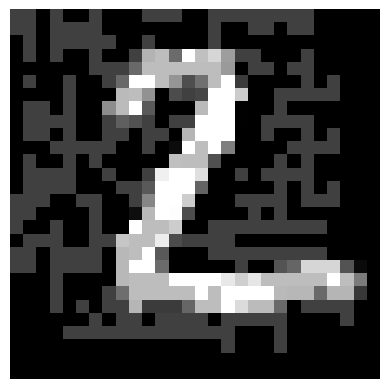

In [3]:
def fgsm_attack(image, epsilon, data_grad):
    perturbed_image = image + epsilon * data_grad
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

def generate_adversarial_examples(model, images, labels, epsilon=0.01):
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)

    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, predictions)

    gradient = tape.gradient(loss, images)
    gradient_sign = tf.sign(gradient)
    adv_images = fgsm_attack(images, epsilon, gradient_sign)

    return adv_images  # .numpy()メソッド不要

# テストデータに対する敵対的攻撃の実行
epsilon = 0.25
adversarial_images = generate_adversarial_examples(model, x_test, y_test, epsilon)

# 結果の可視化
plt.axis('off')
plt.imshow(np.squeeze(adversarial_images[1]), cmap='gray') 

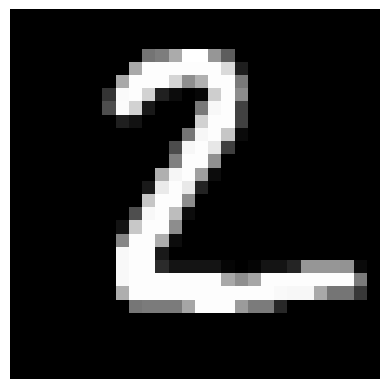

In [4]:
plt.axis('off')
plt.imshow(np.squeeze(x_test[1]), cmap='gray')

In [5]:
#FGSMの成功率
fgsm_loss, fgsm_acc =model.evaluate(adversarial_images, y_test)  

313/313 [==============================] - 1s 3ms/step - loss: 2.8039 - accuracy: 0.3585


In [6]:
np.save('./adversarial_images.npy', adversarial_images)

In [7]:
cdcgan_img = np.load("cdcgan_imgs.npy")
cdcgan_label = np.load("cdcgan_labels.npy")

In [8]:
cdcgan_img.shape

(10000, 28, 28, 1)

In [9]:
cdcgan_label=np.argmax(cdcgan_label,axis=1)
cdcgan_label.shape

(10000,)

In [10]:
#CDCGANの成功率
test_loss, test_acc =model.evaluate(cdcgan_img, cdcgan_label) 

313/313 [==============================] - 1s 4ms/step - loss: 0.3770 - accuracy: 0.9203


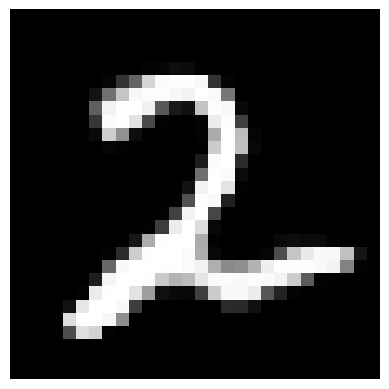

In [11]:
plt.axis('off')
plt.imshow(np.squeeze(cdcgan_img[2024]), cmap='gray')